Dummy strategy to figure out how the components interact with one another

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from typing import List, Any

In [2]:
sns.set(color_codes=True, style='whitegrid', context='paper')
plt.rcParams["figure.figsize"] = 15, 10

In [3]:
df = pd.read_csv(
    "play_data/XBTUSD_trades_191214_0434.csv",
    usecols=[
        "received",
        "size",
        "price"
    ],
    parse_dates=["received"],
    index_col="received",
    nrows=20000
)

df["dollars"] = df["size"] * df["price"]

# parameters
# group_width = 50 * df["dollars"].quantile(0.75)  # arbitrary
group_width = 680850400  # arbitrary
short_ma, long_ma = 5, 10  # maybe can use EWM but will need more parameters

NameError: name 'make_dwap_df' is not defined

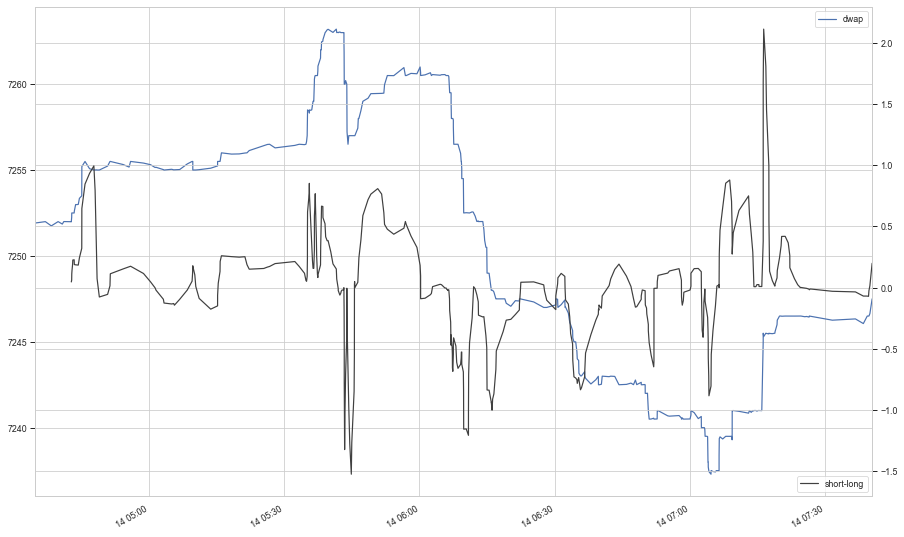

In [35]:
@dataclass
class DWMParameters:
    __slots__ = "group_width", "short_ma_window", "long_ma_window"
    group_width: float
    short_ma_window: int
    long_ma_window: int
        
#     def __repr__(self):
#         return f"{'group_width':12}: {group_width}\n{'short_ma':12}: {short_ma}\n{'long_ma':12}: {long_ma}"
        
@dataclass
class DWMCache:
    __slots__ = "ma_vals", "increasing", "curr_bar", "remaining_width"
    ma_vals: np.array  # each element is dwap, for each item in the window
    increasing: bool  # used to check direction changes to prevent duplicates
    curr_bar: pd.DataFrame  # columns: size, price, dollars
    remaining_width: float # when curr bar full, update MAs 
    
def make_dwap_df_curr_bar(df, group_width):
    
    df["group"] = (df["dollars"].cumsum() // group_width)  # will be affected by different initial conditions
    new_series = {}  # timestamp : dwap
    
    for grp, gdf in df.groupby("group"):
        timestamp = gdf.index[-1] # last timing, prevent lookahead
        dwap = (gdf["dollars"].values * gdf["price"].values).sum() / gdf["dollars"].values.sum()
        
        if grp == df["group"].max():
            curr_bar = gdf[["size", "price", "dollars"]].values  # for cache
            
        new_series[timestamp] = dwap
        
    ddf = pd.Series(new_series, name="dwap").to_frame()
    
    return ddf, curr_bar

def _test():
    ddf, curr_bar = make_dwap_df_curr_bar(df, group_width)

    ma_vals = ddf["dwap"].values[-long_ma:]
    increasing = ma_vals[-short_ma:].sum()/short_ma > ma_vals.sum()/long_ma
    curr_width = (df["dollars"].cumsum().values % group_width)[-1]  # bar has 'leftovers'

    cache = DWMCache(ma_vals, increasing, curr_bar, curr_width)
    params = DWMParameters(group_width, short_ma, long_ma)

    ax1 = ddf.plot()
    ax2 = ax1.twinx()
    ax2.plot(
        ddf["dwap"].rolling(short_ma).mean() - ddf["dwap"].rolling(long_ma).mean(),
        label="short-long", c="0.25"
    )
    plt.legend(loc="lower right")
    return None

_test()

In [34]:
class DollarWeightedMACD:
    
    def __init__(self, df):
        print("initializing")
        group_width = 680850400  # arbitrary, eventually can dynamically adjust
        short_ma, long_ma = 5, 10  # maybe can EWM but will need more parameters
        
        self.ddf, curr_bar = make_dwap_df_curr_bar(df, group_width)

        ma_vals = self.ddf["dwap"].values[-long_ma:]
        increasing = ma_vals[-short_ma:].sum()/short_ma > ma_vals.sum()/long_ma
        rem_width = group_width - (df["dollars"].cumsum().values % group_width)[-1]

        self.cache = DWMCache(ma_vals, increasing, curr_bar, rem_width)
        self.params = DWMParameters(group_width, short_ma, long_ma)
        
    def generate_signal(self, size, price):
        # logic will change depending on new bar or current bar hmm
        # need to come up with a way of calculating new MAs based on old MAs
        
        new_row = np.array([[size, price, size*price]])
        
        self.cache.remaining_width -= new_row[2]
        if remaining_width > 0:  # old bar
            self.cache.curr_bar = np.append(self.cache.curr_bar, new_row, axis=1)
        else:  # new bar
            self.cache.curr_bar = new_row
        
        if True:  # if direction change from increasing to decreasing
            pass
        else:  # if direction change from decreasing to increasing
            pass
        
        print("generating signal")
        dollars = size * price
        if dollars + self.cache.curr_width > self.group_width:  # new bar
            pass
        else:  # current bar
            pass
    
    def update_cache(self, size, price):
        # currently done inside generate signal
        # have to redo logic later if it works 
        print("updating cache")
    
    def update_parameters(self, size, price):
        print("updating parameters")
        
d = DollarWeightedMACD(df)
display(d.ddf)
np.append(
    d.cache.curr_bar,
    np.array([[1,2,3]]),
    axis=0
)

initializing


,dwap
2019-12-14 04:34:42.499730+00:00,7251.913798
2019-12-14 04:36:58.517363+00:00,7251.995481
2019-12-14 04:38:18.113510+00:00,7251.748281
2019-12-14 04:39:48.664416+00:00,7251.996900
2019-12-14 04:40:44.508359+00:00,7251.853599
...,...
2019-12-14 07:39:22.937222+00:00,7246.499334
2019-12-14 07:39:39.934165+00:00,7246.496399
2019-12-14 07:39:45.266087+00:00,7246.500000
2019-12-14 07:39:58.057930+00:00,7246.640280


array([[1.00000e+03, 7.24750e+03, 7.24750e+06],
       [5.00000e+00, 7.24750e+03, 3.62375e+04],
       [4.00000e+02, 7.24750e+03, 2.89900e+06],
       [3.00000e+02, 7.24750e+03, 2.17425e+06],
       [1.00000e+00, 2.00000e+00, 3.00000e+00]])